# Pytorchを用いたCNNの実装

## 概要

機械学習用ライブラリPytorchを用いて、PythonでCNNを実装します。<br>
今回は、CIFAR-10を用いた10クラス認識のモデルを設計し、学習させます。


##  目次

1. データの準備
1. モデルの定義
1. モデルの学習
1. 学習記録のグラフ化
1. モデルのセーブ・ロード
1. モデルを用いたクラス認識予測デモ
1. モデルの中間出力の可視化

の順に実装します。

## データの準備
### 1. 1. ライブラリをインストールします。
- torchsummary
- tqdm

In [ ]:
#pip install torchsummary
#pip install tqdm #conda install tqdmでも可

#pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
#pip install jupyterlab

### 1. 2. ライブラリをインポートします。
- pytorch(torch)
- torchvision
- numpy
- matplotlib
- PIL
- tqdm
- torchsummary
- pylab

In [ ]:
import torch as torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
from torchsummary import summary
from pylab import rcParams

### 1.3. データセット内の教師画像(PILImage)の下処理、変換を定義します。
- **torchvision.transforms**パッケージ内のクラスで行います。transforms.Composeでオブジェクトをまとめて返せます。  
- transfoms.処理一例
    - transforms.RandomHorizontalFlip(p=0.5), 50%で左右反転  
    - transforms.RandomVerticalFlip(p=0.5) 50%で上下反転  
    - transforms.RandomRotation(45) -45~45の範囲でランダムに回転  
    - transforms.ColorJitter(brightness=0.5) 明るさをランダムに0.5倍～1.5倍  
    - transforms.ToTensor()  PILImage -> Tensor, 0~1正規化  
- pytorchではデータをTensor形式で扱います。(listやnumpyと似たような構造を持つ)

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), 
    ])

### 1.4. データセットのロード(画像(PILImage)と正解ラベルが格納されている))
- 有名なデータセットは**torchvision.datasets**クラス内で定義されており、簡単に利用できます。

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
                                             train=True, #訓練データをロード
                                             transform=transform,#上で定義した変換を適用
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
                                             train=False, #検証データをロード
                                             transform=transforms.ToTensor(),
                                             download=True)


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/
Files already downloaded and verified


### 1.5. データセット可視化用に画像(PILImage or Tensor)を壁画する関数を定義します。
- データセットの入力画像(PILImage)をtorchvision.transforms.ToTensor()でTensor型に変換したものを出力します
- 画像を表示するplt.imshow関数の引数の入力画像サイズは(H,W,C)なので(C,H,W)を**np.transpose(numpy,(並びの指定))**で(H,W,C)に変換します

In [ ]:
%matplotlib inline
def show(img):
    npimg = img.numpy() 
    plt.grid(False) 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

### 1.6. データセットの可視化

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
学習画像サイズ torch.Size([3, 32, 32])
ラベル: 9


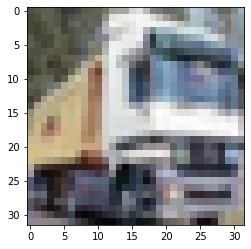

In [ ]:
print (train_dataset)
image, label = train_dataset[1]
print("学習画像サイズ",image.size())
print ("ラベル:",label)
show(image)

### 1.7. データセットをミニバッチ単位に変換します。
- **torch.utils.data.DataLoader**クラスで行います。

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, #バッチあたり64枚
                                           shuffle=True,
                                          num_workers=4)#4プロセスでデータをロード
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2.モデルの定義
### 2.1. モデルの定義(nn.Moduleを継承したクラスでの書き方)
- **__init__**関数でネットワーク層の定義、初期化を行います。
- **forward**関数でモデルの入力→出力の定義、順伝搬の計算を行います。  
    - 定義したネットワーク層に入力(x)を伝搬していきます。
- 全結合ネットワークは**nn.Liner(入力パラメータ数、出力パラメータ数)**で定義します。
    - 画像データを扱う場合、入力パラメータ数は**二次元データを一次元に変換**して入力します。
    - Tensorのサイズ変換には**Tensor.view(軸について要素数を指定)**を用います。

In [ ]:
num_classes = 10#出力クラス数

class AlexNet(nn.Module):
    
    #畳み込みブロック(プーリングなし)
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            
        )
    #畳み込みブロック(プーリングあり)
    def conv_block_pooling(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        #畳み込みブロック群
        self.block1=self.conv_block(3,96)
        self.block2=self.conv_block_pooling(96,256)
        self.block3=self.conv_block(256,384)
        self.block4=self.conv_block_pooling(384,384)
        self.block5=self.conv_block(384,256)
        #全結合ブロック群
        self.classifier= nn.Sequential(
            #6ブロック(ここから全結合層)
            nn.Dropout(p=0.5),
            nn.Linear(256*8*8,1048),
            #7ブロック
            nn.Dropout(p=0.5),
            nn.Linear(1048,1048),
            #8ブロック(出力)
            nn.Linear(1048,num_classes),
        )

    def forward(self, x):
        #1-5ブロック
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        #(N,C,H,W)→(N,C*H*W)
        x = x.view(x.size(0),256*8*8)
        #6-8ブロック
        x = self.classifier(x)
        return x
    
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)#モデルをインスタンス


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()#おまじない
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifer = nn.Linear(256, num_classes)
      
        def forward(self, x):#ここで以前までの定義した関数を組み立てる
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)#全結合層を実装
            return x

print(AlexNet())

### 2.2. モデルの可視化
- **summary(モデル,入力サイズ(チャンネル数、パラメータ数))**クラスで可視化を行います。

In [ ]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
       BatchNorm2d-2           [-1, 96, 32, 32]             192
              ReLU-3           [-1, 96, 32, 32]               0
            Conv2d-4          [-1, 256, 32, 32]         221,440
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
         MaxPool2d-7          [-1, 256, 16, 16]               0
            Conv2d-8          [-1, 384, 16, 16]         885,120
       BatchNorm2d-9          [-1, 384, 16, 16]             768
             ReLU-10          [-1, 384, 16, 16]               0
           Conv2d-11          [-1, 384, 16, 16]       1,327,488
      BatchNorm2d-12          [-1, 384, 16, 16]             768
             ReLU-13          [-1, 384, 16, 16]               0
        MaxPool2d-14            [-1, 38

## 3. モデルの学習
### 3.1. 損失関数、最適化法(オプティマイザー)の定義
- 損失関数は**nn.CrossEntropyLoss()**(ソフトマックス+交差エントロピー)を用います。
- 最適化法には**optim.SGD(適用するモデルの重み、その他ハイパーパラメータの設定・・・)**を用います。

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

### 3.2. 学習の流れ(エポック単位)
- ①画像データと正解ラベルを取り出す
    - tqdmはjupyter内にプログレスバー(進行度)を表示する
- ②画像データとラベルデータ(共にバッチ単位)をデバイス(GPU)に移動
- ③勾配の初期化
- ④モデルの推測(画像データ→各クラスである確率)
- ⑤損失の計算
- ⑥⑤で求めた損失をエポックでの累計損失に加える
    - Tensorから値を取得する場合は、1次元(1要素)に指定してから.item()で取得する必要がある
- ⑦正答率の計算(出力の最大値のインデックスが正解ラベルの場合1を出力をバッチサイズ分行う(.sum())
    - (.maxは()で比較する値の軸を選び、[0]に最大値の値、[1]に最大値のインデックスを持つ)
- ⑧逆伝搬の計算
- ⑨勾配の更新<br>

---全バッチで行う---
- ⑩エポックでの平均誤差の計算
- ⑪エポックでの平均正答率の計算
- 検証データでの損失、精度を学習時と同じアルゴリズムで検証(逆伝搬、勾配の更新は行わない)

*1:学習時には.train()で学習に関連する機能を有効にします。   
*2:検証時には.eval()で学習に関連する機能を有効に、torch.no_grad()で自動微分を停止してから検証を行います。

In [ ]:
num_epochs = 20 #学習エポックの設定

#グラフ作成のためにエポックごとの各値を保存する配列を作成
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

#学習の定義
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i=0#学習回数
    
    net.train() #train *1
    for (images, labels) in tqdm_notebook(train_loader): #①
        images, labels = images.to(device), labels.to(device) #②
        optimizer.zero_grad() #③
        outputs = net(images) #④
        loss = criterion(outputs, labels)#⑤
        train_loss += loss.item()#⑥
        train_acc += (outputs.max(1)[1] == labels).sum().item() #⑦
        loss.backward()#⑧
        optimizer.step()#⑨
    
    avg_train_loss = train_loss / len(train_loader.dataset) #⑩
    avg_train_acc = train_acc / len(train_loader.dataset)   #⑪
    
    net.eval() #val *2
    with torch.no_grad():#自動微分停止 *2
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
    
        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        #グラフ壁画用に各値を配列に格納
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

## 4. 学習記録のグラフ化
- matplotlibを用います。

In [ ]:
#学習のグラフ化
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 5. モデルのセーブ・ロード
### 5.1. モデルのセーブ
- モデルの保存は**(torch.save(model.state_dict,保存先のパス)**で行います。

In [ ]:
torch.save(net.state_dict(),"net.ckpt")#モデルの保存

### 5.2. モデルのロード
- モデルの読み込みは**model.load_state_dict(torch.load(読み込み先のパス))**で行います。

In [ ]:
#学習済みモデルを使用する場合はモデルをロード(CPUで実行する場合。GPU実行時はmap_location...は不要)
net.load_state_dict(torch.load("./net.ckpt",map_location=torch.device('cpu')))

## 6. モデルを用いたクラス認識予測デモ
### 6.1. 予測する画像(猫の背景部分を切り取った画像)の読み込み、前処理
- 画像の読み込み(JpegImageFile)・前処理にはPILライブラリのImageクラスを用います。
    - モデルの入力サイズに画像をリサイズします。
- モデルの入力サイズはバッチ単位なので**Tensor.unsqueeze(追加する軸の位置)**でバッチの次元を追加します。

In [ ]:
image_path=r"./cat_trim.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

### 6.2. モデルによるクラス予測(猫の背景部分を切り取った画像)
- label_nameはモデルの出力インデックスに対応するクラス名を定義しています。
- **nn.Softmax(値の軸)**で得られた出力を合計で1となるような確率に変換します。

In [ ]:
net.eval()
with torch.no_grad():
    #output=net(img.cuda())
    img.to(device)
    output=net(img)
    output=output.cpu()
    label_name=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,9):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")
    

### 6.3. 予測する画像(猫の原画像)の読み込み、前処理

In [ ]:
image_path=r"./cat_origin.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

### 6.4. モデルによるクラス予測(猫の背景部分を切り取った画像)

In [ ]:
net.eval()
with torch.no_grad():
    #output=net(img.cuda())
    img.to(device)
    output=net(img)
    output=output.cpu()
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,9):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")

## 7. モデルの中間出力の可視化
### 7.1. モデルの中間出力
- nn.Moduleを継承したクラスで定義されたモデルでは__init__関数で定義したネットワーク層を個別に取り出すことができます。
    - 入力を逐次的にそれぞれのネットワーク層へ伝搬していくことでそれぞれのネットワーク層の出力を得ています。

In [ ]:
with torch.no_grad():
    #ブロック毎の中間出力を得ていく
    img.to(device)
    #output1=net.block1(img.cuda())
    output1=net.block1(img)
    output2=net.block2(output1)
    output3=net.block3(output2)
    output4=net.block4(output3)
    output5=net.block5(output4)
    #出力をCPUへ
    output1=output1.cpu()
    output2=output2.cpu()
    output3=output3.cpu()
    output4=output4.cpu()
    output5=output5.cpu()

### 7.2. 中間出力の壁画設定
- mataplotlibを用いて壁画します。
- 中間出力をを1チャンネルずつ出力するのでグレースケールで壁画します。
- pylabライブラリのrcParamsクラスを用いることで壁画サイズを10倍に拡大しています。
- output_image関数は引数のネットワーク層での中間出力を10種類壁画する関数です。

In [ ]:
plt.gray()#グレースケールで表示(フィルタは1チャンネルで表示)
rcParams['figure.figsize'] = 10,10#10倍拡大

def output_image(output,block_num):
    output=output.numpy()
    for i in range(0,10):
        ax=plt.subplot(5,10,10*(block_num-1)+(i+1))#5*10個に領域分けしたうちの5*(ブロック数-11)*(i+1)個目を選択
        # 目盛りを無くす。
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(output[0][i])

### 7.3. 中間出力の壁画
- output_image関数を用います。

In [ ]:
output_image(output1,1)
output_image(output2,2)
output_image(output3,3)
output_image(output4,4)
output_image(output5,5)